In [ ]:
! pip install albumentations==0.4.5
! rm -rf radlib/
! git clone https://github.com/vpsingh22/radlib.git

     |████████████████████████████████| 122kB 5.5MB/s 
     |████████████████████████████████| 634kB 17.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=a2414c1780419f72ec1b835f17b6e8d17705160c1c1abd2b1a2adff703ba5b3d
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=c58fb6db068d77dbada5f796e932cbd09c7e47046dd7e9480059d92bb96b4a95
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Cloning into 'radlib'...
remote: Enumerating objec

In [ ]:
cd /content/radlib/

/content/radlib


In [ ]:
! git checkout -b old-state d3d61c0072b9894c42ce45571ea05dde7eb9bd51

Switched to a new branch 'old-state'


In [ ]:
cd /content/

/content


In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensor
from radlib.data.transformations import Transformations
from radlib.data.downloader import Downloader
from radlib.data.dataloader import Dataloader
from radlib.data.utils import cal_mean, cal_std, image_size
from tqdm import tqdm
from radlib.model.regularizer import l1_regularization
from radlib.model.train import train 
from radlib.model.test import val
from radlib.model.network import *
import matplotlib.pyplot as plt
from radlib.plotter import *
import cv2

# from radlib.lr_finder import LRFinder
from radlib.lrfinder_steep_grad import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
downloader = Downloader('./data', 'CIFAR10')
sample = downloader.download_sample(train = True)

Files already downloaded and verified


In [ ]:
batch_size = 512
num_workers = 16
total_epochs = 24
momentum = 0.99


args = {
    'mean': (0.5, 0.5, 0.5),
    'std': (0.5, 0.5, 0.5),
    'train': False
}
args['train'] = True
args['horizontal_flip_prob'] = 0.5
args['vertical_flip_prob'] = 0.0
args['gaussian_blur_prob'] = 0.0
args['rotate_degree'] = 20
args['padding'] = (40, 40)
args['crop'] = (32, 32)
args['cutout_prob'] = 0.8
args['cutout_dim'] = (8, 8)
args['mean'] = cal_mean(sample)  # calculate mean
args['std'] = cal_std(sample)   # calculate standard deviation
# print(args['mean'])
classes = sample.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
transformations = Transformations(**args)
trainset = downloader.download(transformations)
args['train'] = False
transformations = Transformations(**args)
testset = downloader.download(transformations, train = False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:

trainloader = Dataloader.getloader(trainset, batch_size, num_workers)
testloader = Dataloader.getloader(testset, batch_size, num_workers, train = False)

In [ ]:
cuda = torch.cuda.is_available()
print('GPU Available?', cuda)
device = torch.device("cuda" if cuda else "cpu")
torch.manual_seed(1)
if cuda:
    torch.cuda.manual_seed(1)

GPU Available? True


In [ ]:
from torchsummary import summary
model = ResidualModel().to(device)  # Create model
size = image_size(sample)
print(summary(model, input_size = size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
    ResidualBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [ ]:
# start_lr = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
# end_lr = [1, 1, 1, 1, 1]
# num_iter = 100
# for i in range(0, len(start_lr)):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(), lr=start_lr[i], momentum=momentum)
#     lr_finder = LRFinder(model, optimizer, criterion, device=device)
#     lr_finder.range_test(trainloader, end_lr=end_lr[i], num_iter=num_iter, step_mode='linear')
#     print('Loss:', lr_finder.best_loss)
#     _, best_initial_lr = lr_finder.plot()
#     lr_finder.reset()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
Loss: 3.8198343878984446
LR suggestion: steepest gradient
Suggested LR: 4.49E-02


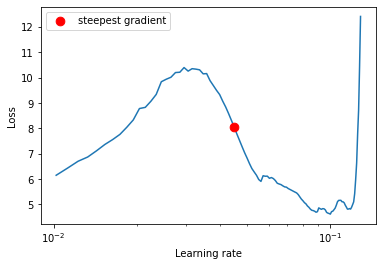

In [ ]:
min_lr = 1e-6
end_lr = 1
num_iter = 10 * len(trainloader)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=momentum, weight_decay = 0.025)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=end_lr, num_iter=num_iter, step_mode='linear')

# Print loss
print('Loss:', lr_finder.best_loss)

# return best initial lr
# Plot learning rate vs loss
_, best_initial_lr = lr_finder.plot()
# print(best_initial_lr)
# Reset graph
lr_finder.reset()

In [ ]:
criterion = nn.CrossEntropyLoss()
print(len(trainloader))
optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=momentum, weight_decay = 0.025)
# scheduler = ReduceLROnPlateau(optimizer)
scheduler = OneCycleLR(
        optimizer, .04, epochs=total_epochs, steps_per_epoch= len(trainloader),
        pct_start=.3, div_factor=20, final_div_factor=1
    )

98


In [ ]:

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for epoch in range(1, total_epochs + 1):
    print(f'Epoch {epoch}:')
    train_loss, train_accuracy = train(model, trainloader, device, optimizer, criterion)
    val_loss, val_accuracy = val(model, testloader, device, criterion)
    train_losses.append(train_loss), train_accuracies.append(train_accuracy)
    val_losses.append(val_loss), val_accuracies.append(val_accuracy)

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0026, Accuracy: 5323/10000 (53.23%)

Epoch 2:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0022, Accuracy: 6096/10000 (60.96%)

Epoch 3:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0019, Accuracy: 6662/10000 (66.62%)

Epoch 4:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0015, Accuracy: 7429/10000 (74.29%)

Epoch 5:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0014, Accuracy: 7655/10000 (76.55%)

Epoch 6:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0012, Accuracy: 7903/10000 (79.03%)

Epoch 7:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0011, Accuracy: 8086/10000 (80.86%)

Epoch 8:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0011, Accuracy: 8123/10000 (81.23%)

Epoch 9:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0010, Accuracy: 8242/10000 (82.42%)

Epoch 10:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0011, Accuracy: 8181/10000 (81.81%)

Epoch 11:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0010, Accuracy: 8354/10000 (83.54%)

Epoch 12:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0010, Accuracy: 8409/10000 (84.09%)

Epoch 13:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 8458/10000 (84.58%)

Epoch 14:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 8558/10000 (85.58%)

Epoch 15:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 8724/10000 (87.24%)

Epoch 16:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0010, Accuracy: 8410/10000 (84.10%)

Epoch 17:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 8712/10000 (87.12%)

Epoch 18:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 8647/10000 (86.47%)

Epoch 19:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 8666/10000 (86.66%)

Epoch 20:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 8654/10000 (86.54%)

Epoch 21:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 8674/10000 (86.74%)

Epoch 22:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0007, Accuracy: 8861/10000 (88.61%)

Epoch 23:


  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 8532/10000 (85.32%)

Epoch 24:


Loss=0.38 Batch_ID=97 Accuracy=89.10: 100%|██████████| 98/98 [00:28<00:00,  3.48it/s]



Validation set: Average loss: 0.0008, Accuracy: 8820/10000 (88.20%)



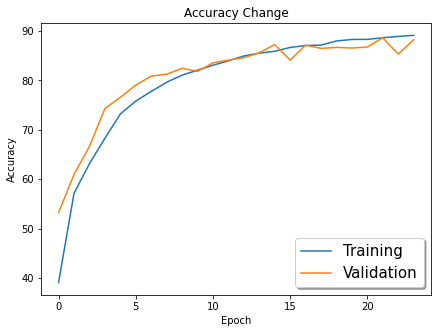

In [ ]:
plot_metric(
    {'Training': train_accuracies, 'Validation': val_accuracies}, 'Accuracy'
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

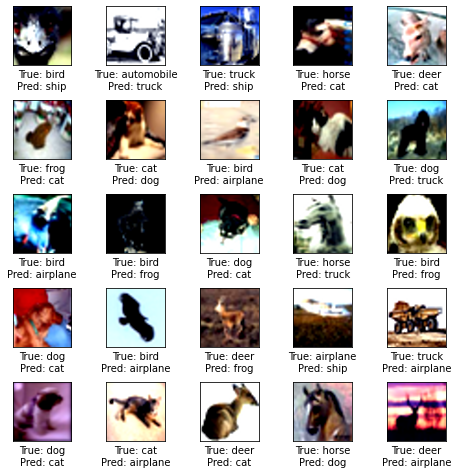

In [ ]:
incorrect_images, incorrect_labels, true_labels = get_incorrect_predictions(testloader, model, device, 25)
plot_images(5, 5, incorrect_images, classes, true_labels, 'incorrect', incorrect_labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
